# PRE-PROCESSING

## 1. Import Libraries

In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import calendar as cal
import logging
import matplotlib.pyplot as plt
import seaborn as sns 
import calendar as cal
import os

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Define standard logging configuration
logging.basicConfig(
    level=logging.INFO,
    filename='../logs/onlineretail.log')

## 2. Load File

In [215]:
try:
    df = pd.read_csv('../data/interim/online_retail_EDA.csv', parse_dates=['InvoiceDate'])
    df_eda = df.copy()
    df.head()
    
except OSError as e:
    logging.error(e)

## 3. Load Global Function

In [216]:
ChangeLogs = {}
def log_changes(num, desc):
    '''Custom function to update ChangeLogs{} dictionary with the number of changed records and the description of the changes.
    Input:
        num - number of changed records to track
        desc - free text description of the changes
    Return: None
    '''
    idx = len(ChangeLogs)
    ChangeLogs[idx] = {'Number': num, 'Description': desc}

## 4. Pre-process Data

In [217]:
display(df.head())

log_changes(df.shape[0], 'Row count before Pre-processing step')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Month,Sales
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04,1.95,13313,United Kingdom,1,19.5
1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04,0.42,13313,United Kingdom,1,10.5
2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04,0.42,13313,United Kingdom,1,10.5
3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04,2.10,13313,United Kingdom,1,10.5
4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04,1.25,13313,United Kingdom,1,12.5


## 4.1 Transform features: Recency, Frequency, Monetary

Create a new Recency column and calculate the date difference.

Since the focus of this project is on clustering, only the non-outliers will be processed by the model. 
It is necessary to perform separate analysis on outliers as they represent extreme behaviours by the customers, such as very big spending and very frequent purchases.

The columns of interest are recency, frequency, and monetary, so all other columnns the dataset are be dropped. 

In [218]:
recent_invdt = df['InvoiceDate'].max() #Ideally, should be the latest day of invoice (near today's date)

df_percust = df.groupby('CustomerID', as_index=False) \
    .agg( 
        LastPurchaseDate = ('InvoiceDate', 'max'),
        Frequency = ('Invoice', 'nunique'),
        Monetary = ('Sales', 'sum'))

df_percust['Recency'] = (recent_invdt - df_percust['LastPurchaseDate']).dt.days
df_percust.head()

log_changes(df_percust.shape[0], 'RFM records per customer')

## 4.2 Plot distribution of Recency, Frequency, and Monetary per Customer

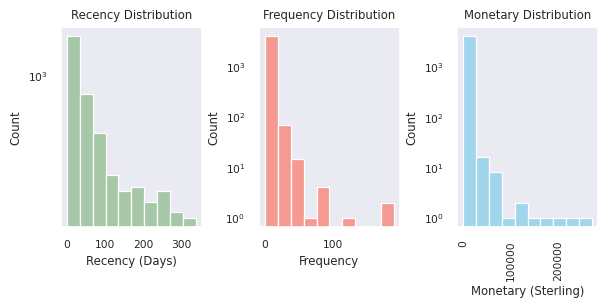

In [219]:
sns.set(font_scale=0.7, style='dark')
fig, ax= plt.subplots(1,3, figsize=(6,3))

#Recency
sns.histplot(df_percust.Recency, bins=10, color='darkseagreen', ax=ax[0])
# ax[0].grid(False)
ax[0].set_xlabel('Recency (Days)')
ax[0].set_yscale('log')
ax[0].set_title('Recency Distribution')

#Frequency
sns.histplot(df_percust.Frequency, bins=10, color='salmon', ax=ax[1])
# ax[1].hist(df_percust.Frequency, bins=3, color='orange')
ax[1].set_xlabel('Frequency')
ax[1].set_title('Frequency Distribution')
ax[1].set_yscale('log')

#Monetary
sns.histplot(df_percust.Monetary, bins=10, color='skyblue', ax=ax[2])
ax[2].set_xlabel('Monetary (Sterling)')
ax[2].tick_params(axis='x', labelrotation=90)
ax[2].set_title('Monetary Distribution')
ax[2].set_yscale('log')


plt.tight_layout(pad=0.5)
plt.show()

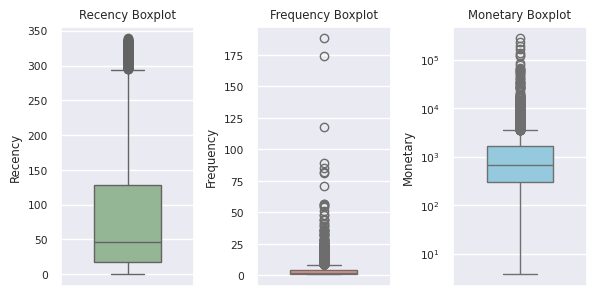

In [220]:
sns.set(font_scale=0.7, style='darkgrid')
fig, ax= plt.subplots(1,3, figsize=(6,3))

#Recency
sns.boxplot(data=df_percust.Recency, color='darkseagreen', ax=ax[0], width=0.5)
ax[0].set_title('Recency Boxplot')

#Frequency
sns.boxplot(data=df_percust.Frequency, color='salmon', ax=ax[1], width=0.5)
ax[1].set_title('Frequency Boxplot')

#Monetary
sns.boxplot(data=df_percust.Monetary, color='skyblue', ax=ax[2], width=0.5)
ax[2].set_title('Monetary Boxplot')
ax[2].set_yscale('log')

plt.tight_layout(pad=1)
plt.show()

There are many outliers as can be seen from the R/F/M boxplots. \
Since the focus of this project is on clustering, only the non-outliers will be processed by the model. 

It is emparative to analyze the outliers as they represent extreme behaviours by the customers, such as high spending and very frequent purchases; therefore, that step will be performed after the modeling.

## 4.3 Outlier detection and handling 

Separate outliers (big spenders and frequent spenders) from the rest of the data 

In [221]:
#Create a function for extracting outliers
def outliers(p_df, col):
    '''Function for computing outliers. 
    Input: (1)Dataframe, (2)column name.
    Return: rows of outliers in a dataframe'''

    q1 = p_df[col].quantile(0.25)
    q3 = p_df[col].quantile(0.75)
    iqr = q3 - q1
    outlier = p_df[( p_df[col] > (q3 + 1.5*iqr)) | (p_df[col] < (q1 - 1.5*iqr)) ]
    return outlier

#Big spenders: Monetaty outliers
df_m_outliers = outliers(df_percust, 'Monetary')

#Frequent buyers: Frequency outliers
df_f_outliers = outliers(df_percust, 'Frequency')

print('Monetary outliers: ', df_m_outliers.shape[0])
print('Frequency outliers: ', df_f_outliers.shape[0])

log_changes(df_m_outliers.shape[0], 'Monetary outliers')
log_changes(df_f_outliers.shape[0], 'Frequency outliers')

Monetary outliers:  402
Frequency outliers:  412


In [222]:
# Save to file for further analysis

pp_path = '../data/processed/'
m_ol_fname = 'online_retail_m_outliers.csv'
f_ol_fname = 'online_retail_f_outliers.csv'

m_ol_file = os.path.join(pp_path, m_ol_fname)
f_ol_file = os.path.join(pp_path, f_ol_fname)

df_m_outliers.to_csv(m_ol_file, index=False)
df_f_outliers.to_csv(f_ol_file, index=False)

In [223]:
# ##Try
# df_m_outliers

Subset the non-outliers for subsequent processing.

In [224]:
df = df_percust[ (~df_percust.index.isin(df_m_outliers.index)) &  (~df_percust.index.isin(df_m_outliers.index)) ]
print(f'No. of NON-outlier records:  {df.shape[0]} from {df_percust.shape[0]} or {round(df.shape[0]*100/df_percust.shape[0],2)} %' )

log_changes(df.shape[0], 'Non-outliers in RFM records for modeling')

No. of NON-outlier records:  3817 from 4219 or 90.47 %


In [225]:
# #Try
# df

Plot non-outliers based on Recency, Frequency, and Monetary

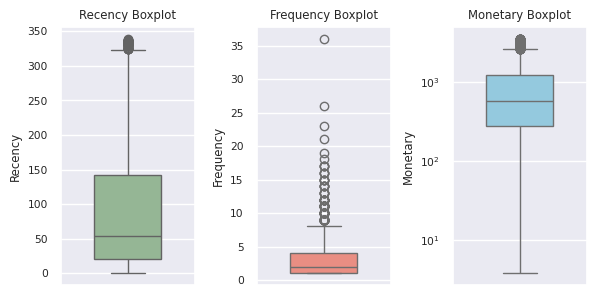

In [226]:
sns.set(font_scale=0.7, style='darkgrid')
fig, ax = plt.subplots(1,3, figsize=(6,3))

sns.boxplot(data=df.Recency, color='darkseagreen', ax=ax[0], width=0.5)
ax[0].set_title('Recency Boxplot')

sns.boxplot(data=df.Frequency, color='salmon', ax=ax[1], width=0.5)
ax[1].set_title('Frequency Boxplot')

sns.boxplot(data=df.Monetary, color='skyblue', ax=ax[2], width=0.5)
ax[2].set_title('Monetary Boxplot')
plt.yscale('log')

plt.tight_layout(pad=1)
plt.show()

## 4.4 Scaling

Prepare data for scaling. The columns of interest are Recency, Frequency, and Monetary.\
The other columns will be set as indices and will be re-appended to the scaled columns.

In [227]:
df = df.set_index(['CustomerID', 'LastPurchaseDate'])

# Back up the RFM indices and columns
rfm_idx = df.index
rfm_cols = df.columns

df

,,Frequency,Monetary,Recency
CustomerID,LastPurchaseDate,,,
12348,2011-09-25,3,904.44,75
12349,2011-11-21,1,1757.55,18
12350,2011-02-02,1,334.40,310
12352,2011-11-03,8,2506.04,36
12353,2011-05-19,1,89.00,204
...,...,...,...,...
18280,2011-03-07,1,180.60,277
18281,2011-06-12,1,80.82,180
18282,2011-12-02,2,178.05,7


Scale/Standardize the data

In [228]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(df)

In [229]:
# Rebuild the scaled dataframe

df_scaled = pd.DataFrame(rfm_scaled, columns=rfm_cols, index=rfm_idx)

# Log the changes
log_changes(df_scaled.shape[0], 'Scaled RFM records for modeling')

In [230]:
# Check if normalized. Mean ~ 0 and Standard Deviation ~ 1.
print(df_scaled.mean())
print('\n', df_scaled.std(ddof=0))

Frequency    4.560728e-17
Monetary    -1.861521e-17
Recency     -2.792282e-17
dtype: float64

 Frequency    1.0
Monetary     1.0
Recency      1.0
dtype: float64


Visualize the distribution after standardization

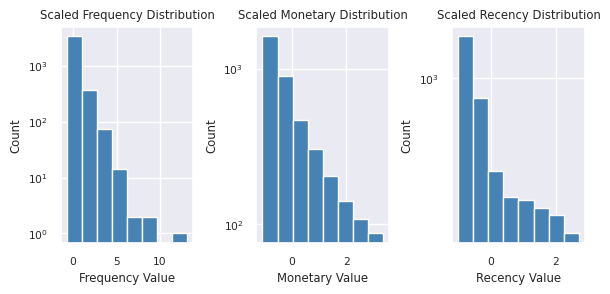

In [231]:
sns.set(font_scale=0.7, style='darkgrid')
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(6,3), squeeze=False)

for idx, col in enumerate(rfm_cols):

    axes[0][idx].hist(df_scaled[col], bins=8, color='steelblue')
    axes[0][idx].set_xlabel(col + ' Value')
    axes[0][idx].set_ylabel('Count')
    axes[0][idx].set_yscale('log')
    # plt.axvline(df_rfm_col[col].mean(), size)
    axes[0][idx].set_title('Scaled ' + col + ' Distribution')

plt.tight_layout()
plt.show()    

### 4.5 Show Changes and Save File 

In [232]:
df_logs = pd.DataFrame(ChangeLogs).T
df_logs

,Number,Description
0,367023,Row count before Pre-processing step
1,4219,RFM records per customer
2,402,Monetary outliers
3,412,Frequency outliers
4,3817,Non-outliers in RFM records for modeling
5,3817,Scaled RFM records for modeling


In [233]:
# Save Changes to .csv file
preplog_fname = 'prep_log.csv'
preplog_path = '../logs/'
preplog_file = os.path.join(preplog_path, preplog_fname) 
df_logs.to_csv(preplog_file, index=False)

In [234]:
# Save processed files to .csv

pp_path = '../data/processed'

unscaled_fname = 'online_retail_unscaled.csv'
scaled_fname = 'online_retail_scaled.csv'

unscaled_file = os.path.join(pp_path, unscaled_fname)
scaled_file = os.path.join(pp_path, scaled_fname)

df.to_csv(unscaled_file)
df_scaled.to_csv(scaled_file)